In [253]:
# Cell 1 – robust loader for blue & red trajectory files

import numpy as np
from pathlib import Path

BLUE_FILE = Path("trajectories_o_trimmed.output")   # blue trajectory (2-column)
RED_FILE  = Path("traj_o_marker.output")            # red  trajectory (CSV)

def read_traj(path: Path) -> np.ndarray:
    """
    Handles two line formats automatically:

      1. CSV style:    17,606,368           → take last two ints → (606,368)
      2. Two-column:   360 330              → take both ints   → (360,330)

    Lines beginning with '#' or blank lines are ignored.
    """
    pts = []
    with path.open() as f:
        for ln in f:
            ln = ln.strip()
            if not ln or ln.startswith('#'):
                continue
            # replace commas with spaces so split() works
            nums = [int(s) for s in ln.replace(',', ' ').split()]
            if len(nums) == 2:          # already (x,y)
                x, y = nums
            elif len(nums) >= 3:        # e.g. frame,cx,cy
                x, y = nums[-2], nums[-1]
            else:
                continue                # malformed line
            pts.append((x, y))
    return np.asarray(pts, dtype=int)

blue_pts = read_traj(BLUE_FILE)
red_pts  = read_traj(RED_FILE)

print(f"Blue trajectory: {blue_pts.shape[0]} points")
print(f"Red  trajectory: {red_pts.shape[0]} points")



Blue trajectory: 80 points
Red  trajectory: 24 points


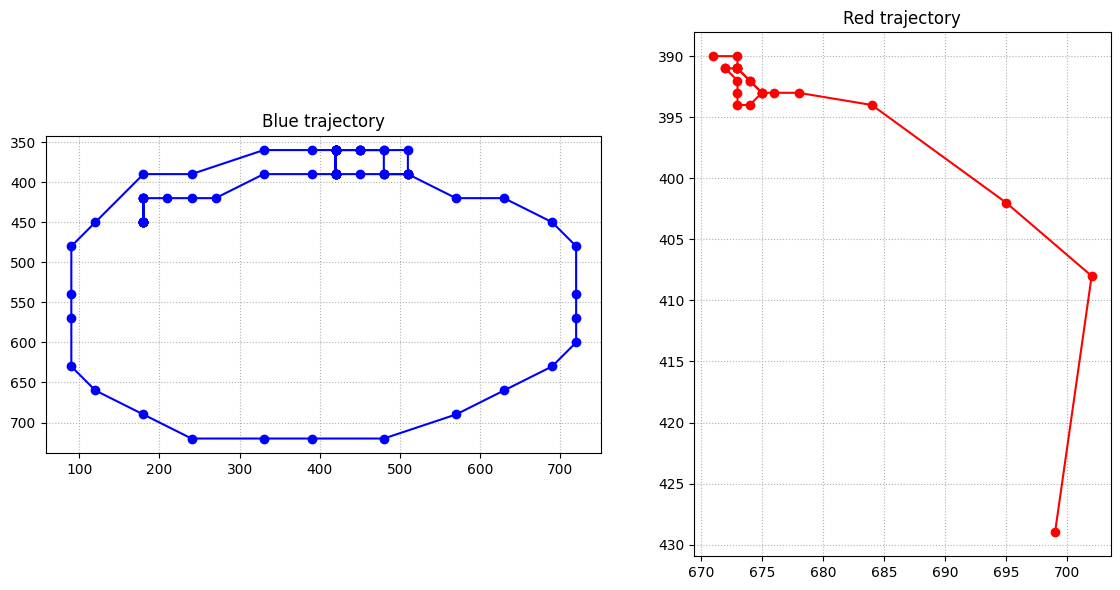

In [254]:
# Cell 2 – plot blue trajectory and red trajectory in separate panels
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ── blue ──────────────────────────────────────────
axes[0].plot(blue_pts[:, 0], blue_pts[:, 1], '-o', color='blue')
axes[0].set_title("Blue trajectory")
axes[0].set_aspect('equal', 'box')
axes[0].invert_yaxis()          # image coordinates: (0,0) at top-left
axes[0].grid(ls=':')

# ── red ───────────────────────────────────────────
axes[1].plot(red_pts[:, 0], red_pts[:, 1], '-o', color='red')
axes[1].set_title("Red trajectory")
axes[1].set_aspect('equal', 'box')
axes[1].invert_yaxis()
axes[1].grid(ls=':')

plt.tight_layout()
plt.show()


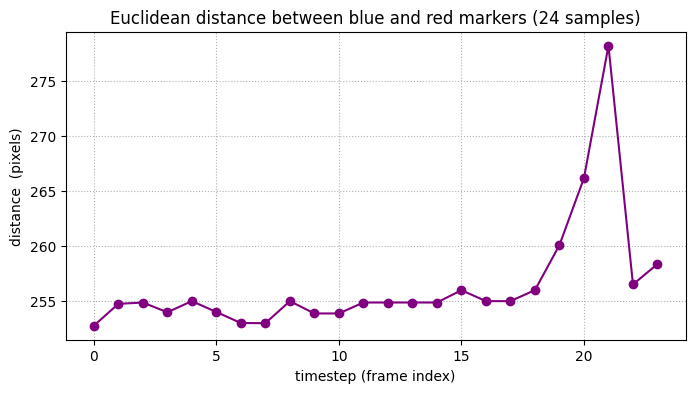

In [249]:
# Cell 3 – distance-vs-time plot

import numpy as np
import matplotlib.pyplot as plt

# use the shorter length so we have matching pairs
N = min(len(blue_pts), len(red_pts))
if N == 0:
    raise ValueError("One of the trajectories is empty!")

dist = np.linalg.norm(blue_pts[:N] - red_pts[:N], axis=1)   # Euclidean distance

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(N), dist, '-o', color='purple')
ax.set_xlabel("timestep (frame index)")
ax.set_ylabel("distance  (pixels)")
ax.set_title(f"Euclidean distance between blue and red markers ({N} samples)")
ax.grid(ls=':')
plt.show()

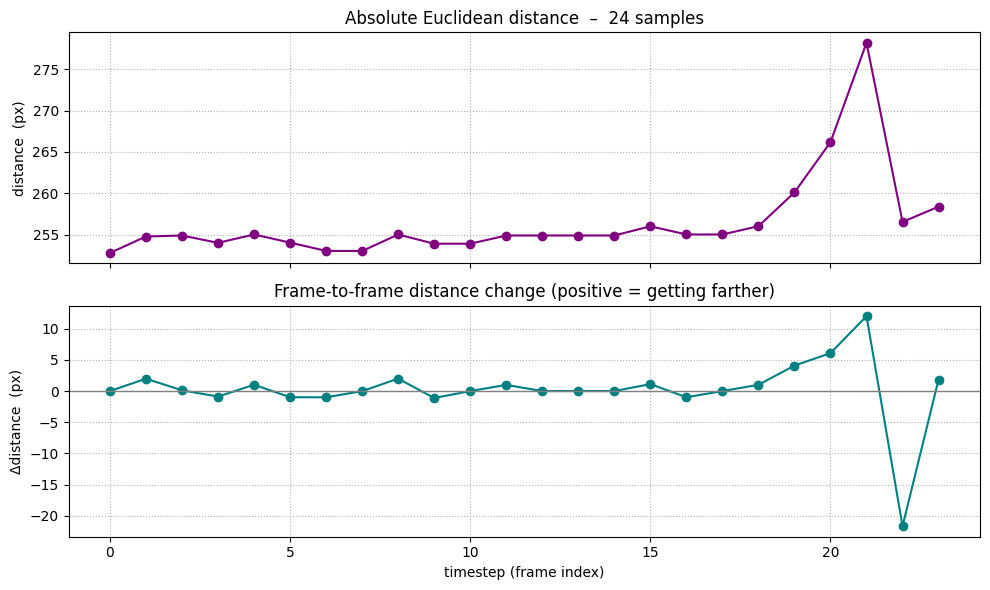

In [250]:
# Cell 3b – distance and distance-change vs. timestep
import numpy as np
import matplotlib.pyplot as plt

# ------------- prepare data -------------------------------------------------
N = min(len(blue_pts), len(red_pts))
if N == 0:
    raise ValueError("One of the trajectories is empty")

dist = np.linalg.norm(blue_pts[:N] - red_pts[:N], axis=1)          # |B-R|
dvar = np.diff(dist, prepend=dist[0])                               # Δ|B-R|  (frame-to-frame)

# ------------- plot ---------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# absolute distance
ax1.plot(range(N), dist, '-o', color='purple')
ax1.set_ylabel("distance  (px)")
ax1.set_title(f"Absolute Euclidean distance  –  {N} samples")
ax1.grid(ls=':')

# variation (first difference)
ax2.plot(range(N), dvar, '-o', color='teal')
ax2.axhline(0, color='gray', lw=1)
ax2.set_xlabel("timestep (frame index)")
ax2.set_ylabel("Δdistance  (px)")
ax2.set_title("Frame-to-frame distance change (positive = getting farther)")
ax2.grid(ls=':')

plt.tight_layout()
plt.show()

In [251]:
# Cell 4 – average distance variation

# Skip the artificial first element (same as prepend)
delta = np.diff(dist)                 # same as dist[1:] - dist[:-1]

avg_signed = np.mean(delta)           # can be near zero if ups & downs cancel
avg_abs    = np.mean(np.abs(delta))   # average magnitude of change

print(f"Average signed Δdistance : {avg_signed:.2f} px per frame")
print(f"Average absolute Δdistance: {avg_abs:.2f} px per frame")


Average signed Δdistance : 0.24 px per frame
Average absolute Δdistance: 2.56 px per frame


Chosen flat run (2, 7, 6), pruning up to frame 7
Kept frames: 8 … 23   (total 16)


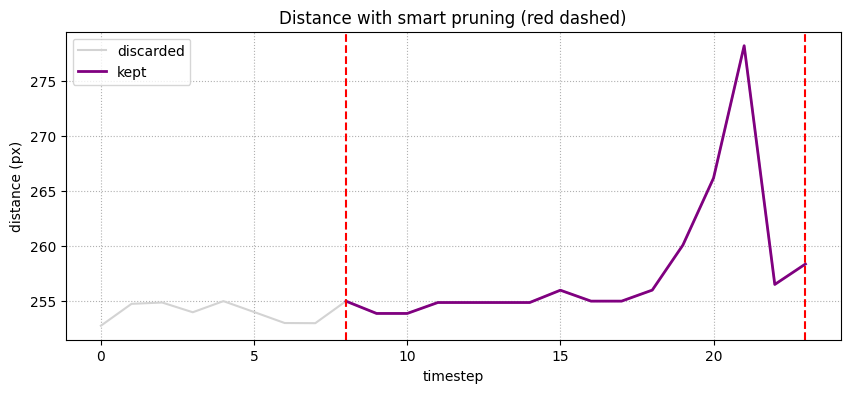

In [252]:
# Cell 5 – smarter pruning based on longest flat runs (≥5 frames)

# ------------- build idle mask -------------------------------------------
delta = np.abs(np.diff(dist, prepend=dist[0]))
idle  = delta < (1.0)*avg_abs            # True where "flat", o,r,t,u take all

# ------------- find all idle runs ----------------------------------------
runs = []
run_start = None
for i, flag in enumerate(idle):
    if flag and run_start is None:
        run_start = i
    if (not flag or i == len(idle)-1) and run_start is not None:
        run_end = i if flag else i-1
        length  = run_end - run_start + 1
        if length >= 5:                 # only keep long-enough runs
            runs.append((run_start, run_end, length))
        run_start = None

if not runs:
    print("No flat run ≥5 found; keeping full sequence.")
    start = 0
else:
    mid = len(idle) // 2
    # longest run in first half & second half
    first_half  = max((r for r in runs if r[1] <  mid), default=None,
                      key=lambda r: r[2])
    second_half = max((r for r in runs if r[0] >= mid), default=None,
                      key=lambda r: r[2])
    # choose the longer of the two
    chosen = None
    if first_half and second_half:
        chosen = first_half if first_half[2] >= second_half[2] else second_half
    else:
        chosen = first_half or second_half

    # prune everything before the chosen flat run
    start = chosen[1] + 1              # keep after the flat segment
    print(f"Chosen flat run {chosen}, pruning up to frame {start-1}")

# ------------- trailing idle pruning (same as before) ---------------------
run = 0
end = len(idle) - 1
for i in range(len(idle) - 1, -1, -1):
    flag = idle[i]
    run  = run + 1 if flag else 0
    if run >= 5:
        end = i - 1
    if not flag and run < 5:
        break

if start >= end:
    print("⚠ Nothing left after pruning — keeping full sequence.")
    start, end = 0, len(dist)-1

print(f"Kept frames: {start} … {end}   (total {end-start+1})")

# ------------- plot -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(range(len(dist)), dist, color='lightgray', label='discarded')
ax.plot(range(start, end+1), dist[start:end+1], color='purple',
        label='kept', linewidth=2)
ax.axvline(start, color='red', ls='--')
ax.axvline(end,   color='red', ls='--')
ax.set_xlabel("timestep")
ax.set_ylabel("distance (px)")
ax.set_title("Distance with smart pruning (red dashed)")
ax.grid(ls=':')
ax.legend()
plt.show()

# a : 31 … 109   (total 79)
# b : 16 … 75   (total 60)
# c : 27 … 72   (total 46)
# d : 7 … 64  (total 58)
# e : 5 … 78  (total 74)
# f : 0 … 77   (total 78)
# g : 13 … 80   (total 68)
# h : 28 … 73   (total 46)
# i : 19 … 52   (total 34)
# j : 22 … 68   (total 47)
# k : 20 … 80   (total 61)
# l : 19 … 75   (total 57)
# m : 22 … 94   (total 73)
# n : 20 … 76   (total 57)
# o : 24 … 80   (total 24)
# p : 25 … 76   (total 52)
# q : 20 … 100   (total 81)
# r : 0 … 20   (total 21)
# s : 24 … 95   (total 72)
# t : 0 … 30   (total 31)
# u : 0 … 85   (total 86)


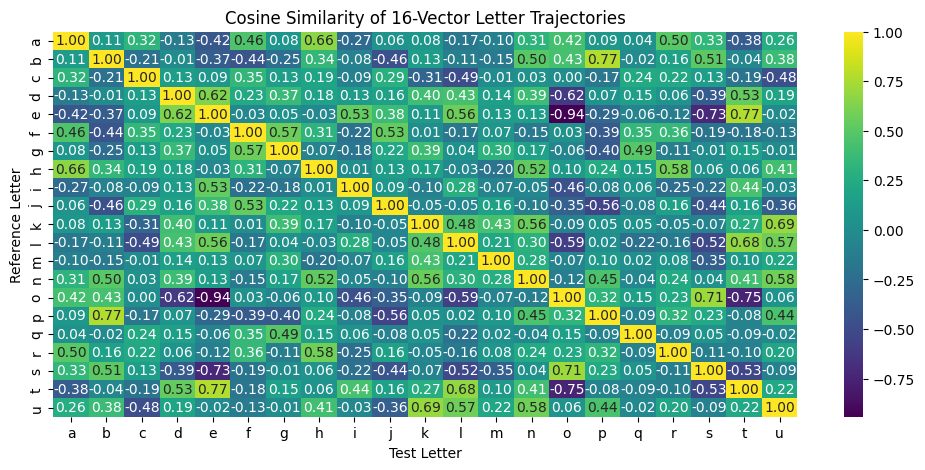

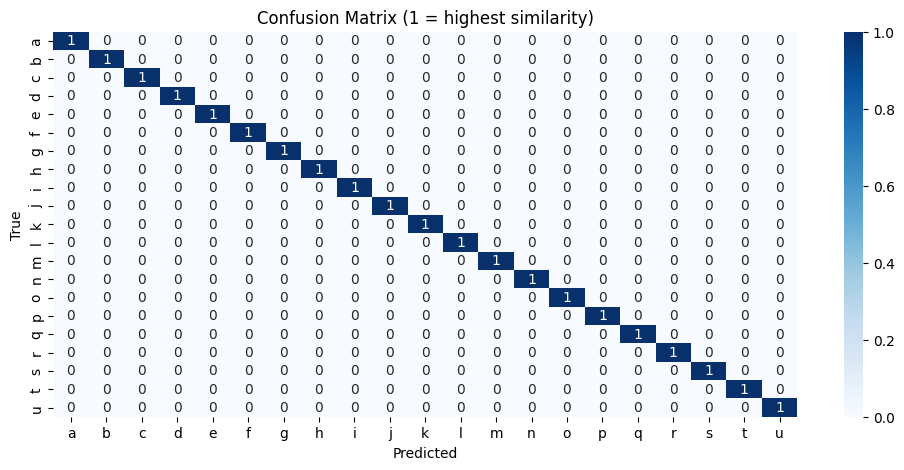

In [10]:
# Cell X: Build trajectory vectors and compute confusion matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
# 1) Load trimmed blue trajectories for letters a…u
letters = [chr(ord('a') + i) for i in range(21)]
traj_vecs = {}
base_dir   = Path("sample_data")
for L in letters:
    file_path = base_dir / f"trajectories_{L}_trimmed.output"
    if not file_path.exists():
        print(f"[skip] {file_path} missing");  continue
    # read x y pairs
    pts = np.loadtxt(f"sample_data/trajectories_{L}_trimmed.output")

    # resample to 17 points equally spaced by arc length
    # compute segment lengths
    seg_len = np.linalg.norm(pts[1:] - pts[:-1], axis=1)
    cumlen  = np.concatenate([[0], seg_len.cumsum()])
    total   = cumlen[-1]
    targets = np.linspace(0, total, 17)

    new_pts = np.zeros((17, 2))
    new_pts[0], new_pts[-1] = pts[0], pts[-1]

    for k in range(1, 16):
        s = targets[k]
        idx = np.searchsorted(cumlen, s)
        if cumlen[idx] == s:
            new_pts[k] = pts[idx]
        else:
            t = (s - cumlen[idx - 1]) / (cumlen[idx] - cumlen[idx - 1])
            new_pts[k] = pts[idx - 1] * (1 - t) + pts[idx] * t

    # compute 16 vectors
    vecs = new_pts[1:] - new_pts[:-1]  # shape (16,2)
    traj_vecs[L] = vecs.reshape(-1)    # flatten to length 32

# 2) Compute cosine similarity matrix
n = len(letters)
sim_mat = np.zeros((n, n))

for i, L1 in enumerate(letters):
    v1 = traj_vecs[L1]
    for j, L2 in enumerate(letters):
        v2 = traj_vecs[L2]
        sim_mat[i, j] = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# 3) Build confusion matrix: predict j = argmax(sim_mat[i])
conf_mat = np.zeros_like(sim_mat, dtype=int)
pred = sim_mat.argmax(axis=1)
for i, j in enumerate(pred):
    conf_mat[i, j] = 1

# 4) Plot similarity heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(sim_mat, xticklabels=letters, yticklabels=letters,
            annot=True, fmt=".2f", cmap="viridis")
plt.title("Cosine Similarity of 16-Vector Letter Trajectories")
plt.xlabel("Test Letter")
plt.ylabel("Reference Letter")
plt.show()

# 5) Plot confusion matrix
plt.figure(figsize=(12, 5))
sns.heatmap(conf_mat, xticklabels=letters, yticklabels=letters,
            annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (1 = highest similarity)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [220]:
# trim_trajectory.py
import pathlib

INPUT = pathlib.Path("trajectories_u.output")
OUTPUT = pathlib.Path("trajectories_u_trimmed.output")

with INPUT.open() as fin, OUTPUT.open("w") as fout:
    for line in fin:
        parts = line.strip().split()
        # only keep columns 3 & 4 (0-based indices 2 & 3)
        if len(parts) >= 4:
            fout.write(f"{parts[2]} {parts[3]}\n")

In [8]:
import os, pathlib, pprint
pprint.pprint(os.listdir())              # root
pprint.pprint(os.listdir("sample_data")) # if it exists

['.config', '.ipynb_checkpoints', 'sample_data']
['trajectories_o_trimmed.output',
 'trajectories_g_trimmed.output',
 'trajectories_k.output',
 'trajectories_c_trimmed.output',
 'traj_d_marker.output',
 'trajectories_p.output',
 'trajectories_d.output',
 'trajectories_p_trimmed.output',
 'trajectories_r.output',
 'trajectories_e.output',
 'trajectories_b_trimmed.output',
 'traj_g_marker.output',
 'trajectories_h_trimmed.output',
 'traj_k_marker.output',
 'trajectories_h.output',
 'trajectories_o.output',
 'traj_u_marker.output',
 'traj_p_marker.output',
 'trajectories_g.output',
 '.ipynb_checkpoints',
 'traj_j_marker.output',
 'trajectories_i_trimmed.output',
 'trajectories_f.output',
 'trajectories_a.output',
 'trajectories_j_trimmed.output',
 'traj_i_marker.output',
 'trajectories_s_trimmed.output',
 'trajectories_q.output',
 'traj_n_marker.output',
 'traj_f_marker.output',
 'traj_b_marker.output',
 'trajectories_u_trimmed.output',
 'traj_o_marker.output',
 'trajectories_a_trimmed.ou